# Workplace attitudes towards mental health and their impact on employee productivity
A Tutorial and Introduction to the Data Science Pipeline by Gabrielle Baniqued

# Introduction
Do workplace culture and attitudes about mental health affect how well employees work?

# Data Collection

Sometimes, data will have to be collected (ex. web scraping), parsed through, and organized before we can actually start using it. In this case, however, the data has been collected for us. We will be using an OSMI (Open Sourcing Mental Illness, LTD) survey data from 2014 and 2016 regarding mental health in the tech workplace.

The survey data can be downloaded from Kaggle:

- OSMI Mental Health in Tech Survey (2014) - https://www.kaggle.com/osmi/mental-health-in-tech-survey

- OSMI Mental Health in Tech Survey (2016, ongoing) - https://www.kaggle.com/osmi/mental-health-in-tech-2016

Both of these surveys aimed to measure attitudes towards mental health and frequency of mental health disorders among tech workers.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import seaborn as sns
import warnings

In [2]:
# supresses warnings because we're dangerous
warnings.filterwarnings('ignore')

In [3]:
# removes max display for rows and cols
pd.set_option("display.max_rows", None, "display.max_columns", None)

# import 2014 survey using pandas
survey_2014 = pd.read_csv('survey.csv')

In [4]:
# displays first 5 rows of 2014 survey data in a DataFrame
survey_2014.head(3)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN


In [5]:
# Here, I decide to drop the free-response column [comments],
# since I know I don't want to include that data in my analysis.
# I also drop the Timestamp column ahead of time, since the 2016
# survey lacks Timestamp data, and we eventually want to combine the two.
subset_2014 = survey_2014.drop(columns=['comments', 'Timestamp'])

# Here, I drop any invalid rows (if present), where all the values are NaN.
subset_2014.dropna(how='all', inplace=True)

Let's get familiar with the data in the dataset.

- treatment: Have you sought treatment for a mental health condition?
- work_interfere: If you have a mental health condition, do you feel that it interferes with your work?
- no_employees: How many employees does your company or organization have?
- remote_work: Do you work remotely (outside of an office) at least 50% of the time?
- tech_company: Is your employer primarily a tech company/organization?
- benefits: Does your employer provide mental health benefits?
- care_options: Do you know the options for mental health care your employer provides?
- wellness_program: Has your employer ever discussed mental health as part of an employee wellness program?
- seek_help: Does your employer provide resources to learn more about mental health issues and how to seek help?
- anonymity: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?
- leave: How easy is it for you to take medical leave for a mental health condition?
- mentalhealthconsequence: Do you think that discussing a mental health issue with your employer would have negative consequences?
- physhealthconsequence: Do you think that discussing a physical health issue with your employer would have negative consequences?
- coworkers: Would you be willing to discuss a mental health issue with your coworkers?
- supervisor: Would you be willing to discuss a mental health issue with your direct supervisor(s)?
- mentalhealthinterview: Would you bring up a mental health issue with a potential employer in an interview?
- physhealthinterview: Would you bring up a physical health issue with a potential employer in an interview?
- mentalvsphysical: Do you feel that your employer takes mental health as seriously as physical health?
- obs_consequence: Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?
- comments: Any additional notes or comments

In [6]:
# import 2016 survey using pandas
survey_2016 = pd.read_csv('mental-heath-in-tech-2016_20161114.csv')

# display first 5 rows of the 2016 data
survey_2016.head(3)

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you have medical coverage (private insurance or state-provided) which includes treatment of mental health issues?,Do you know local or online resources to seek help for a mental health disorder?,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?","If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?","If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?","If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",Do you believe your productivity is ever affected by a mental health issue?,"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Why or why not?,Would you bring up a mental health issue with a potential employer in an interview?,Why or why not?.1,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a menta

Here, you can see that the column names are different from the 2014 data; there are actually new columns in the 2016 data! In order to combine these two DataFrames, we are going to rename the 2016 columns, drop any columns non-existing in the 2014 survey data, then concatenate the two DataFrames.

The documentation of all features used in this section are linked below:

## LINKS TO ADD

In [7]:
# The DataFrame.rename method requires a dictionary for renaming
# which we are filling below, beginning with defaultdict().
rename_dict = defaultdict()

# Inserting keys as the columns to be renamed
for col in survey_2016.columns:
    rename_dict[col] = ""

# Values list for the rename dict
rename_list = ['self_employed', 'no_employees', 'tech_company', 'primary_role', 'benefits', 
               'care_options', 'wellness_program', 'seek_help', 'anonymity',
              'leave', 'mental_health_consequence', 'phys_health_consequence',
              'coworkers', 'supervisor', 'mental_vs_physical', 'obs_consequence',
              'coverage', 'resources', 'revtoclients', 'revclient_consequence',
              'revtocoworkers', 'revcoworker_consequence', 'work_interfere', 'interfere_amt',
              'prev_employers', 'prev_benefits', 'prev_care_options', 'prev_wellness_program',
              'prev_seek_help', 'prev_anonymity', 'prev_mentalhealthconsequence',
              'prev_physhealthconsequence', 'prev_coworkers', 'prev_supervisors',
              'prev_mentalvsphysical', 'prev_obs_consequence', 'mentalhealthinterview',
              'mentalhealthinterview_why', 'physhealthinterview', 'physhealthinterview_why',
              'identify_mental', 'viewed_negatively_mental', 'willingtoshare', 'obs_unsupportive',
              'obs_unsupportive_affect', 'family_history', 'disorder_past', 'disorder_curr','disorder_past_yes',
              'disorder_past_maybe', 'diagnosed', 'diagnosed_conditions', 'treatment',
               'work_interfere_withtreat', 'work_interfere_notreat', 'Age', 'Gender', 'Country',
              'state', 'Country_repeat', 'state_repeat', 'work_position', 'remote_work'] 

# Inserting the values to rename
for i in range(len(rename_list)):
    k = list(rename_dict.keys())[i]
    v = rename_list[i]
    rename_dict[k] = v

# Based on the dict we created above, we rename the columns here.
subset_2016 = survey_2016.rename(columns=rename_dict)

# Similar to the 2014 DataFrame, I am dropping the free response columns.
subset_2016.drop(columns=['mentalhealthinterview_why', 'physhealthinterview_why'])

# Similarly, I drop any invalid rows (if present), where all the values are NaN.
subset_2016.dropna(how='all', inplace=True)

# Outputting the modified version
subset_2016.head(3)

,self_employed,no_employees,tech_company,primary_role,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_vs_physical,obs_consequence,coverage,resources,revtoclients,revclient_consequence,revtocoworkers,revcoworker_consequence,work_interfere,interfere_amt,prev_employers,prev_benefits,prev_care_options,prev_wellness_program,prev_seek_help,prev_anonymity,prev_mentalhealthconsequence,prev_physhealthconsequence,prev_coworkers,prev_supervisors,prev_mentalvsphysical,prev_obs_consequence,mentalhealthinterview,mentalhealthinterview_why,physhealthinterview,physhealthinterview_why,identify_mental,viewed_negatively_mental,willingtoshare,obs_unsupportive,obs_unsupportive_affect,family_history,disorder_past,disorder_curr,disorder_past_yes,disorder_past_maybe,diagnosed,diagnosed_conditions,treatment,work_interfere_withtreat,work_interfere_notreat,Age,Gender,Country,state,Country_repeat,state_repeat,work_position,remote_work
0,0,26-100,1.0,NaN,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,No,No,Maybe,Yes,I don't know,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"No, none did",N/A (not currently aware),I don't know,None did,I don't know,Some of them,None of them,Some of my previous employers,Some of my previous employers,I don't know,None of them,Maybe,NaN,Maybe,NaN,Maybe,"No, I don't think they would",Somewhat open,No,NaN,No,Yes,No,NaN,NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",0,Not applicable to me,Not applicable to me,39,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Sometimes
1,0,6-25,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,No,No,Maybe,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"Yes, they all did",I was aware of some,None did,Some did,"Yes, always",None of them,None of them,"No, at none of my previous employers",Some of my previous employers,Some did,None of them,Maybe,It would depend on the health issue. If there ...,No,While mental health has become a more prominen...,"No, I don't think it would","No, I don't think they would",Somewhat open,No,NaN,Yes,Yes,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Rarely,Sometimes,29,male,United States of America,Illinois,United States of America,Illinois,Back-end Developer|Front-end Developer,Never
2,0,6-25,1.0,NaN,No,NaN,No,No,I don't know,Neither easy nor difficult,Maybe,No,Maybe,Maybe,I don't know,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"No, none did",N/A (not currently aware),None did,Some did,I don't know,I don't know,Some of them,Some of my previous employers,I don't know,I don't know,Some of them,Yes,"They would provable need to know, to Judge if ...",Yes,"Stigma, mainly.",Maybe,Maybe,Somewhat open,Maybe/Not sure,Yes,No,Maybe,No,NaN,NaN,No,NaN,1,Not applicable to me,Not applicable to me,38,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Always


In [8]:
# Dropping columns that aren't found in the 2014 survey (I know. After we did all that work to rename it all nicely!)
subset_2016.drop(columns=['Country_repeat', 'state_repeat', 'work_position','interfere_amt',
              'prev_employers', 'prev_benefits', 'prev_care_options', 'prev_wellness_program',
              'prev_seek_help', 'prev_anonymity', 'prev_mentalhealthconsequence',
              'prev_physhealthconsequence', 'prev_coworkers', 'prev_supervisors',
              'prev_mentalvsphysical', 'prev_obs_consequence', 'mentalhealthinterview', 'physhealthinterview',
              'identify_mental', 'viewed_negatively_mental', 'willingtoshare', 'obs_unsupportive',
              'obs_unsupportive_affect', 'disorder_past', 'disorder_curr','disorder_past_yes',
              'disorder_past_maybe', 'diagnosed', 'diagnosed_conditions', 'revtoclients', 'revclient_consequence',
              'revtocoworkers', 'revcoworker_consequence', 'coverage', 'primary_role', 'resources'], inplace=True)

In [9]:
# Now, combining the two DataFrames is easy.
survey = pd.concat([subset_2014, subset_2016])
survey.head(3)

,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,mentalhealthinterview_why,physhealthinterview_why,work_interfere_withtreat,work_interfere_notreat
0,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN,NaN,NaN,NaN
1,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN,NaN,NaN,NaN
2,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN,NaN,NaN,NaN


# Data Management and Representation

If we wanted to use all of our survey data, it would be important for us to clean all of it. In this case, we are looking ahead and letting our later part of the project (machine learning, modeling, etc.) inform the data we should tidy.

## Preparing for later modeling - target and predictor values
Now that our two surveys are combined into one DataFrame, we can decide on our predictors and target for our modeling later on.

Out of all of the columns (in our modified DataFrame), two measures of mental wellness can be found in treatment and work_interfere. My specific inquiry: the effect of mental health on productivity, is best measured by work_interfere. <b>We will choose <i>work_interfere</i> as our target.</b>

### Thinking ahead: Tidying Gender, Age, family_history
Intuitively, I can identify some 'obvious' predictors: gender, age, family_history. These predictors have to do with the employee his/her/themself.

However, for my specific inquiry, I would like to try to identify predictors on behalf of the workplace: workplace size, culture, attitudes towards mental health and determine their signifiance. In addition to predictors related to the employee, we will also focus on predictors regarding the workplace.

<b>Gender:</b> This question in the survey was free response, leaving us a lot of data to clean up. Gender is also increasingly being understood as non-binary, i.e., not just Male/Female. We will clean up and group the gender responses into three categories: Male, Female, and Nonbinary.

<b>Age:</b> After getting rid of any invalid ages, we need to decide to either keep it as a continuous variable, or to divide it into sections (maybe by ranges or by seniority at the company). We'll take a look at the data and then decide later on. 

<b>family_history:</b> This question is answered by 'Yes', 'No', or 'I don't know'. We may want to drop the 'I don't know' value or replace it with NaN values. Similarly, we'll take a look at the data and decide later on.

### Thinking ahead: Tidying no_employees and measuring workplace culture/attitude
<b>no_employees:</b> The survey already provides us with grouped company sizes: 1-5, 6-25, 26-100, 100-500, 500-1000, More than 1000. We will stick with these groupings.

Measuring workplace culture/attitude: However, 'workplace culture' or 'attitudes' are more difficult to measure based on the data we are given. Our plan is, for each response, to score the responses related to the workplace culture/attitudes questions (which are generally answered in a 'Yes, Maybe, No' fashion) and assign a workplace_score to each employee/row. For simplicity, we will weight each question equally.

<b>However, we can't just naively assign Yes as +1 and No as -1,</b> since the meaning of the answer depends on the value of the question. So, we will determine the intention of the questions, classify them as such, and then score 'positive answers' by incrementing 1, 'negative answers' by decrementing 1, and 'netural answers' with a 0, unaffecting the score.

In [10]:
# Right away, we want to remove all rows related to a non-tech company.
# This will allow any conclusions or discussions to be more focused.
survey.drop(survey[survey['tech_company'] == 'No'].index, inplace = True)

In [11]:
# Deciding which columns we'd like to keep in our DataFrame
# Each list indicates the relevance of the columns; this is
# purely for clarity reasons, we concatenate the lists as cols
employee_ind = ['Gender', 'Age', 'family_history']
workplace_ind = ['benefits', 'care_options', 'wellness_program', 'seek_help',
                 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence',
                'coworkers', 'supervisor', 'mental_vs_physical', 'obs_consequence', 
                'no_employees']
target = ['work_interfere', 'work_interfere_withtreat', 'work_interfere_notreat']

# concatenated list of all cols to keep
cols = employee_ind + workplace_ind + target

# retrieves subset of DataFrame to be used for the remainder of the project
survey = survey[cols]

In [12]:
# Tidying up gender - Since this question was a free-response question, we have
# to clean up all of the options that intended to say Male or Female. I chose to handle
# this column by manually sending in a list of values to DataFrame.replace, including
# misspellings and handling different cases by converting all responses to lowercase.
survey['Gender'] = survey['Gender'].str.lower()

# Replacing values for 'Male'
survey['Gender'].replace(to_replace=['male', 'man', 'm', 'cis male', 
                                     'cisdude', 'dude', 'malr', 'dude',
                                     'male-ish', 'maile', 'mail'], 
                         value='Male', inplace=True)

# Replace values for 'Female'
survey['Gender'].replace(to_replace=['female', 'f', 'woman', 'queer/she/they', 'trans woman',
                                    'femail', 'cis-female/femme', 'femake', 'female (trans)',
                                    'female (cis)', 'cis female'], 
                         value='Female', inplace=True)

# Replacing all other values and classifying under 'Nonbinary', i.e., not under the binary of M/F.
survey['Gender'].replace(to_replace=['non-binary', 'nonbinary', 'unicorn', 'enby', 'genderqueer', 'agender', 
                                     'neuter', 'queer', 'bigender', 'androgynous', 'nb masculine', 'androgyne',
                                    'ostensibly male', 'Guy (-ish) ^_^', 'male leaning androgynous',
                                    'ostensibly male, unsure what that really means'], 
                         value='Nonbinary', inplace=True)

# Certain values were not classified and dropped, such as nonsensical answers ('Nah', 'p', 'A little about you')
# NaN values were also dropped. The below code updates the survey DataFrame as described.
survey = survey[survey['Gender'].isin(['Male', 'Female', 'Nonbinary'])]

In [13]:
survey.replace(to_replace=['Not applicable to me', 'Don\'t know', 'I don\'t know'], value=np.nan, inplace=True)

# There are a handful of invalid ages, such as values well above 100 and negative values.
# Here, we decide to omit minors from the survey and ages greater than 80.
survey['Age'] = np.where(survey['Age'] < 18, np.nan, survey['Age'])
survey['Age'] = np.where(survey['Age'] >= 80, np.nan, survey['Age'])

<p><b>Handling work_interfere differences between 2014 and 2016</b></p>
One of the changes between the 2014 and 2016 surveys that presents a problem for my specific inquiry is that the 2016 survey asks for level of work interference due to mental health with or without effective treatment. The 2014 survey asks for work interference without the added conditions.

The code below consolidates the two columns from 2016 into the one work_interfere column based on the following conditions:
<li>If one of the two columns is a NaN value, the non-NaN value is used.</li>
<li>If both are NaN, no action is taken, since the work_interfere column will either have a value or NaN value in the cell by default</li>
<li>If both are not NaN values, we use random.choice() to randomly choose between the two options.</li>

Afterwards, we drop the 2016 columns (we don't need them anymore!) All non-NaN values should be under the work_interfere column now.

In [14]:
# Iterate through the survey DataFrame to handle work_interfere as described above
for row in survey.iterrows():
    wi_t = row[1]['work_interfere_withtreat']
    wi_nt = row[1]['work_interfere_notreat']
    if wi_t != np.nan and wi_nt == np.nan:
        row[1]['work_interfere'] = wi_t
    elif wi_t == np.nan and wi_nt != np.nan:
        row[1]['work_interfere'] = wi_nt
    elif wi_t != np.nan and wi_nt != np.nan:
        row[1]['work_interfere'] = random.choice([wi_t, wi_nt])

# drops 2016 survey work_interfere columns
survey.drop(columns=['work_interfere_withtreat', 'work_interfere_notreat'], inplace=True)

After we've handled the differences between the 2014 and 2016 work_interfere responses, we can group them for clarity. The groups are as follows:
<li>No, Never, and Rarely -> Little to No Interference</li>
<li>Sometimes -> Moderate Interference</li>
<li>Yes, Often -> Significant Interference</li>

In [15]:
# Uses DataFrame.replace to group work_interfere as described above
survey['work_interfere'].replace(to_replace=['No', 'Never', 'Rarely'], value='Little to No Interference', inplace=True)
survey['work_interfere'].replace(to_replace=['Sometimes'], value='Moderate Interference', inplace=True)
survey['work_interfere'].replace(to_replace=['Yes', 'Often'], value='Significant Interference', inplace=True)
survey['work_interfere'].replace(to_replace=['Unsure'], value=np.nan, inplace=True)

<p>As we discussed earlier, we will be create our own scoring to determine a company's workplace culture and attitudes. We will call this <b>workplace_score.</b> The following questions/values will be used to determine the score.</p>
<p></p>
<li> benefits: Does your employer provide mental health benefits? </li>
<li> care_options: Do you know the options for mental health care your employer provides?</li>
<li> wellness_program: Has your employer ever discussed mental health as part of an employee wellness program?</li>
<li> seek_help: Does your employer provide resources to learn more about mental health issues and how to seek help?</li>
<li> anonymity: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?</li>
<li> leave: How easy is it for you to take medical leave for a mental health condition?</li>
<li> mentalhealthconsequence: Do you think that discussing a mental health issue with your employer would have negative consequences?</li>
<li> physhealthconsequence: Do you think that discussing a physical health issue with your employer would have negative consequences?</li>
<li> coworkers: Would you be willing to discuss a mental health issue with your coworkers?</li>
<li> supervisor: Would you be willing to discuss a mental health issue with your direct supervisor(s)?</li>
<li> mentalvsphysical: Do you feel that your employer takes mental health as seriously as physical health?</li>
<li> obs_consequence: Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?</li>
<p></p>
We will intuitively classify the questions as a 'positive question' or a 'negative question'. A positive question is one where 'yes' will increase the score, and 'no' will decrease the score. A 'negative question' will work in the opposite way. Any other questions that don't fit in this binary will be classified and scored individually. This will be reflected in the code below:

In [16]:
# Classifying questions into 'positive questions' and 'negative questions'
pos_qs = ['benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'supervisor', 'coworkers', 'mental_vs_physical']
neg_qs = ['mental_health_consequence', 'phys_health_consequence', 'obs_consequence']
other_qs = ['leave']

In [17]:
# we will put all of the scores in a list to send in
# as a parameter to pd.Series to create a new column
scores = []

# Calculates a score for each row based on how we
# classified the questions above
for row in survey.iterrows():
    score = 0
    for col in pos_qs:
        if row[1][col] == 'Yes':
            score += 1
        elif row[1][col] == 'No':
            score -= 1
    for col in neg_qs:
        if row[1][col] == 'No':
            score += 1
        elif row[1][col] == 'Yes':
            score -= 1
    for col in other_qs:
        if row[1][col] in ['Somewhat easy', 'Very easy']:
            score += 1
        elif row[1][col] in ['Somewhat difficult', 'Very difficult']:
            score -= 1
    
    # I don't want to deal with negative scores. Since the lowest possible
    # score is -12, I will add 12 to each score, making the lowest possible
    # score 0, instead of -12.
    scores.append(score + 12)
    
# Adds scores into the survey DataFrame as a new column    
survey['workplace_score'] = pd.Series(scores)

In [18]:
# Casts the no_employees as strings to use as an axis-value later
survey['no_employees'] = survey['no_employees'].astype(str)

# Exploratory Data Analysis

## Learning about our data
Now that we've tidied up our data and organized it according to our inquiry, it will be helpful for us to understand the data we're using. The code below outputs distributions and countplots for us to make observations about our dataset. The observations we make will inform how we will approach our predictions.

<p><b>Age</b></p>
The distribution for age has a right skew, with most tech employees falling between the ages of their mid-20s and late 30s.

<AxesSubplot:xlabel='Age', ylabel='Count'>

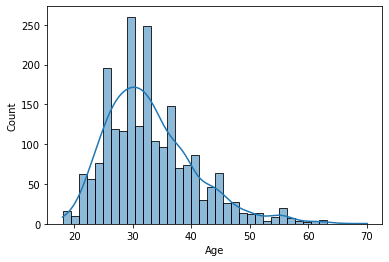

In [19]:
# Plots the Age column as a histogram
# kde refers to the Kernel Density Estimation, which
# gives us a rough estimate of the distribution by age.
sns.histplot(survey['Age'].dropna(), kde=True)

<p><b>Family History of Mental Illness (family_history)</b></p>
The plot below shows that less than half of respondents report having a known family history of mental illness.

<AxesSubplot:xlabel='family_history', ylabel='count'>

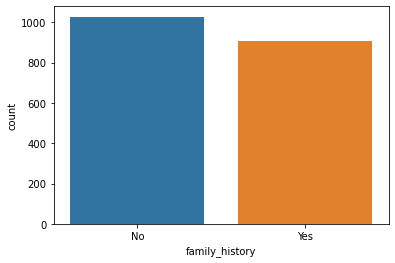

In [20]:
# Shows count of individuals who report having a
# family history of mental illness or not
sns.countplot(survey['family_history'].dropna())

<p><b>Gender</b></p>
Again, it is not surprising that a survey about the tech workplace, which is male-dominated, to be male-dominated.

<AxesSubplot:xlabel='Gender', ylabel='count'>

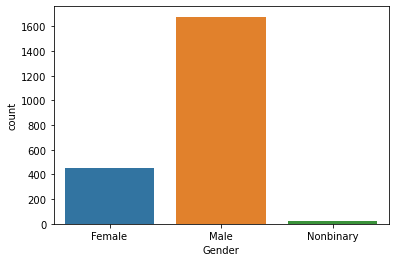

In [21]:
# Shows count of individuals by gender
sns.countplot(survey['Gender'].dropna())

<p><b>Number of Employees (no_employees)</b></p>
Using the grouping determined by the survey, most respondents work in a company of sizes 6-25 or 26-100, and many respondents also work in a significantly larger company of more than 1000 employees.

<AxesSubplot:xlabel='no_employees', ylabel='count'>

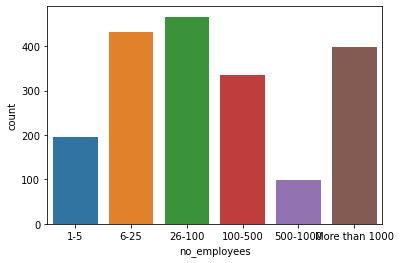

In [22]:
sns.countplot(survey['no_employees'].dropna(), 
              order = ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'])

## Exploring how our possible predictors interact with our target value
Using FacetGrid from seaborn, we can see the distribution of certain variables (our predictors) based on another value (our target, work_interfere). Each level of interference displays its own distribution based on the predictor values. This way, we can let the data, without training or fitting, inform our next steps.

<p><b>Distribution of Levels of Work Interference by Age</b></p>

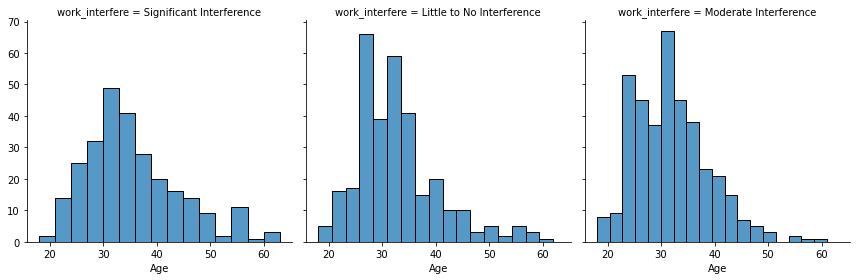

In [23]:
# Displays a distribution by age for each category of work_interfere
g = sns.FacetGrid(survey, col='work_interfere', height=4)
g = g.map(sns.histplot, 'Age')

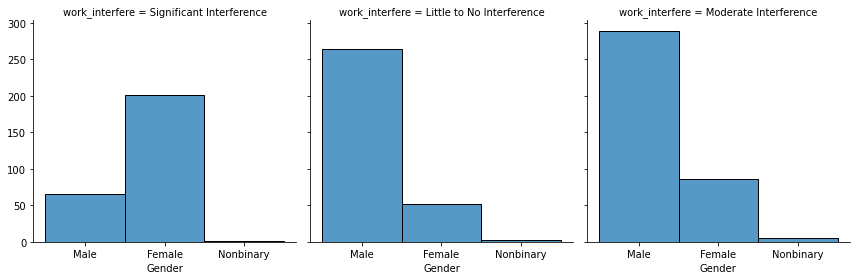

In [29]:
# Displays a distribution by gender for each category of work_interfere
g = sns.FacetGrid(survey, col='work_interfere', height=4)
g = g.map(sns.histplot, 'Gender')

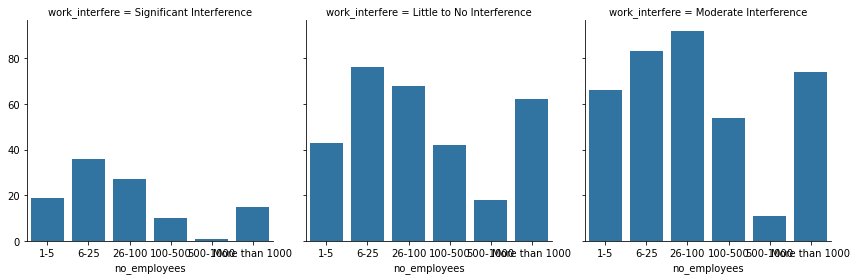

In [25]:
# Displays a distribution by number of employees for each category of work_interfere
# Here, I continue to use a countplot over a histplot, since the latter lacks the order parameter,
# which allows me to manually order the x-axis.
g = sns.FacetGrid(survey, col='work_interfere', height=4)
g = g.map(sns.countplot, 'no_employees', order = ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'])

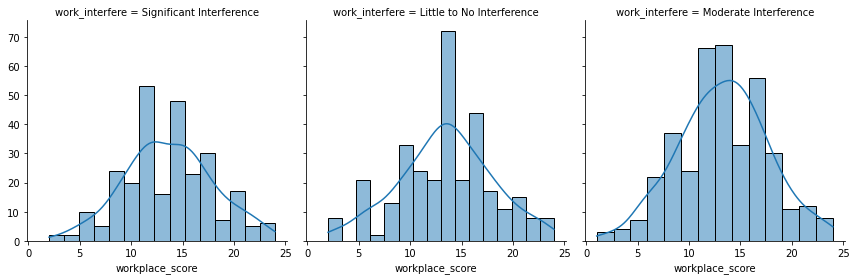

In [26]:
# Displays a distribution by age for each category of work_interfere
g = sns.FacetGrid(survey, col='work_interfere', height=4)
g = g.map(sns.histplot, 'workplace_score', kde=True)

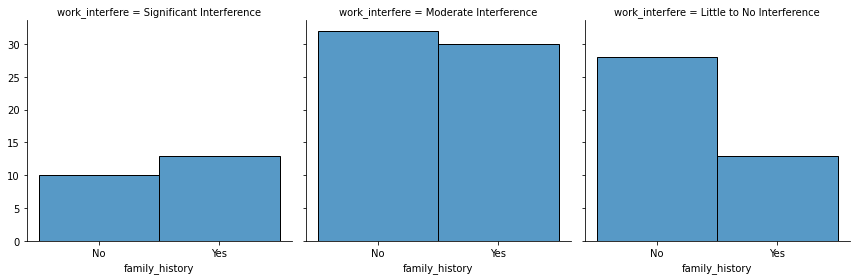

In [27]:
# Displays a distribution by family_history for each category of work_interfere
s = survey.dropna()
g = sns.FacetGrid(s, col='work_interfere', height=4)
g = g.map(sns.histplot, 'family_history')

If this is by chance my last submission, then GG. We tried! Thank you TAs. I tried.